In [ ]:
!conda install conda-forge::transformers

In [6]:
!pip install supervision

  Obtaining dependency information for supervision from https://files.pythonhosted.org/packages/50/1a/971a415d67011854c2c59716c49b3de151d54b422c6dd0a6489e0152b42e/supervision-0.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for defusedxml<0.8.0,>=0.7.1 from https://files.pythonhosted.org/packages/07/6c/aa3f2f849e01cb6a001cd8554a88d4c77c5c1a31c95bdf1cf9301e6d9ef4/defusedxml-0.7.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless>=4.5.5.64 from https://files.pythonhosted.org/packages/71/19/3c65483a80a1d062d46ae20faf5404712d25cb1dfdcaf371efbd67c38544/opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 58.5 MB/s eta 0:00:00:00:0100:01


In [ ]:
# Avoid "NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported."
!pip install -U datasets

Detections(xyxy=array([[ 4.0163315e+01,  7.0811531e+01,  1.7554710e+02,  1.1798414e+02],
       [ 3.3324170e+02,  7.2550095e+01,  3.6832874e+02,  1.8766360e+02],
       [-2.2602081e-02,  1.1496592e+00,  6.3972717e+02,  4.7376108e+02],
       [ 1.3240833e+01,  5.2054653e+01,  3.1401868e+02,  4.7092737e+02],
       [ 3.4540176e+02,  2.3853779e+01,  6.4037164e+02,  3.6872171e+02]],
      dtype=float32), mask=None, confidence=array([0.99822026, 0.99600214, 0.9954744 , 0.9988005 , 0.9986784 ],
      dtype=float32), class_id=array([75, 75, 63, 17, 17]), tracker_id=None, data={})


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


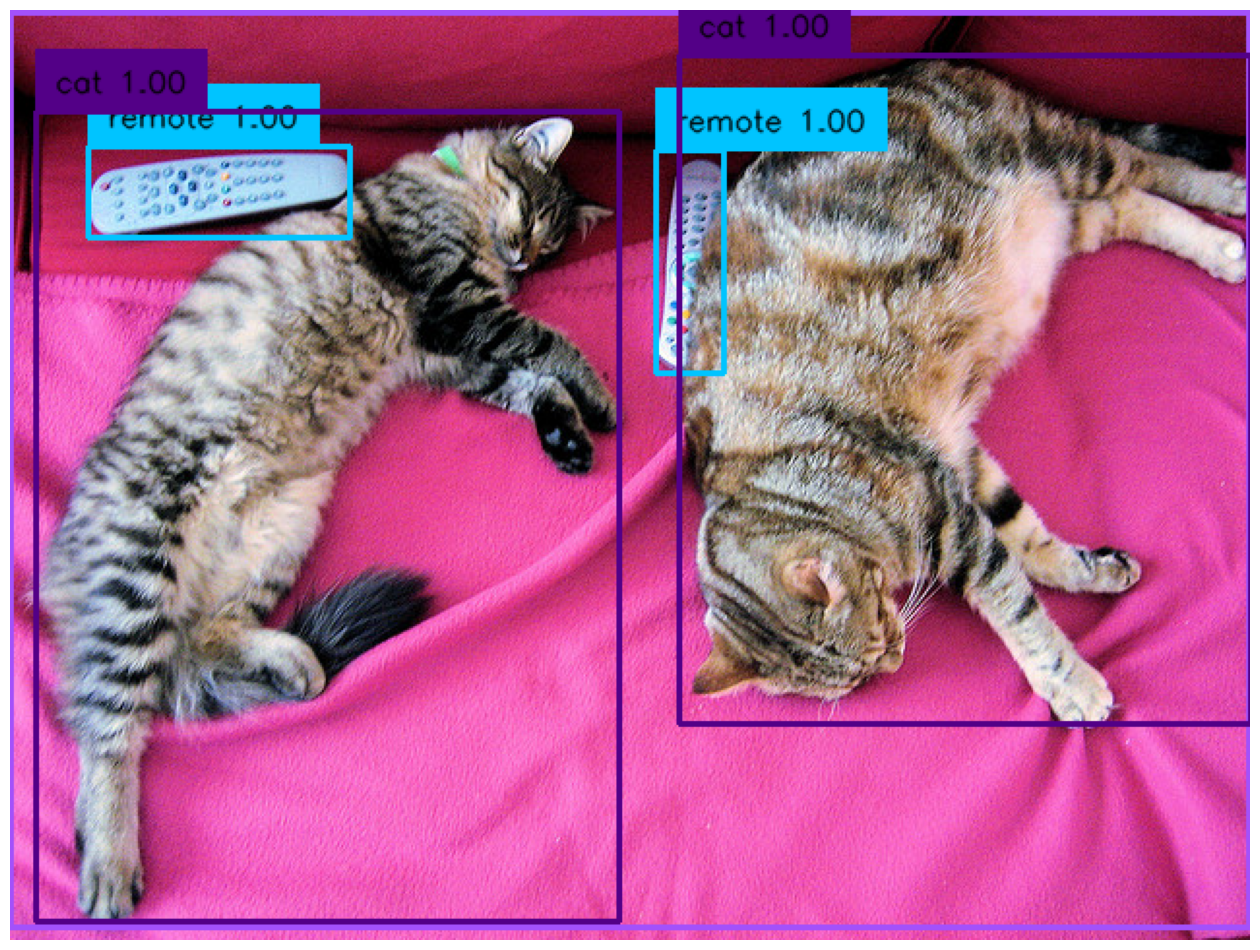

In [14]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import supervision as sv

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

CONFIDENCE_TRESHOLD = 0.8
IOU_TRESHOLD = 0.8

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=CONFIDENCE_TRESHOLD)[0]

# for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]
#     print(
#             f"Detected {model.config.id2label[label.item()]} with confidence "
#             f"{round(score.item(), 3)} at location {box}"
#     )

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

print(detections)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, 
    labels=labels
)

%matplotlib inline  
sv.plot_image(frame, (16, 16))

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension
        
        return pixel_values, target



In [1]:
from datasets import load_dataset

coco = load_dataset("HuggingFaceM4/COCO")
coco

/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for HuggingFaceM4/COCO contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/HuggingFaceM4/COCO
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'],
        num_rows: 566747
    })
    validation: Dataset({
        features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'],
        num_rows: 25010
    })
    test: Dataset({
        features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'],
        num_rows: 25010
    })
})

In [3]:
coco["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'filepath': 'COCO_val2014_000000522418.jpg',
 'sentids': [681330, 686718, 688839, 693159, 693204],
 'filename': 'COCO_val2014_000000522418.jpg',
 'imgid': 1,
 'split': 'restval',
 'sentences': {'tokens': ['a',
   'woman',
   'wearing',
   'a',
   'net',
   'on',
   'her',
   'head',
   'cutting',
   'a',
   'cake'],
  'raw': 'A woman wearing a net on her head cutting a cake. ',
  'imgid': 1,
  'sentid': 681330},
 'cocoid': 522418}

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image